# compute spectra on mitgcm outputs

---

In [1]:
import os
import numpy as np
import dask
import xarray as xr

from utils import *

In [2]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client.restart()
client.upload_file('utils.py')

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:121: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
client

Client Scheduler: tcp://10.148.1.21:8786 Dashboard: http://10.148.1.21:8787,Cluster Workers: 118 Cores: 472 Memory: 1180.00 GB


In [13]:

data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)
print('Total number of iterations: %d' %len(iters))

#Niters = 1000
#iters = iters.isel(time=slice(0,Niters))
#time = time.isel(iters=slice(0,Niters))

#ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))


Total number of iterations: 4096


/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.1-py3.6.egg/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.1-py3.6.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.1-py3.6.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 4096)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

In [14]:
chunks={'time': len(time), 'face':1,  'i': 100, 'j': 100}
%time ds = ds.chunk(chunks)
# 10 iters: ok
# 100 iters: ok
# 1000 iters: ok (30s)
# all: ok

CPU times: user 31.8 s, sys: 648 ms, total: 32.5 s
Wall time: 32.4 s


In [15]:
%time eta = ds['Eta'].isel(face=1).persist()

In [17]:
import xrft

In [19]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0.,drop=False).mean(dim=('i','j'))
E = E.astype('f8').rename('eta_power_spectrum ()')

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xrft-0.1-py3.6.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [20]:
%time E.load()

distributed.utils - ERROR - [Errno 122] Disk quota exceeded
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 232, in f
    result[0] = yield make_coro()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1267, in _gather
    traceback)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/six.py", lin

OSError: [Errno 122] Disk quota exceeded

distributed.utils - ERROR - [Errno 122] Disk quota exceeded
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 232, in f
    result[0] = yield make_coro()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1267, in _gather
    traceback)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/six.py", lin

OSError: [Errno 122] Disk quota exceeded

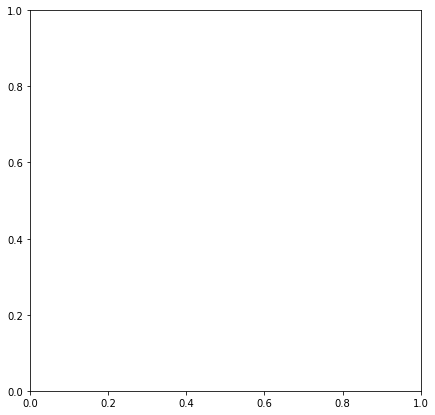

In [22]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E.plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel('')
#ax.set_ylim([1e-1,1e5])

In [25]:
print(E.values)

distributed.utils - ERROR - [Errno 122] Disk quota exceeded
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 232, in f
    result[0] = yield make_coro()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1267, in _gather
    traceback)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/six.py", lin

OSError: [Errno 122] Disk quota exceeded